In [1]:
# ライブラリのロード
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import lightgbm as lgb
import optuna.integration.lightgbm as opt_lgb

import sklearn.model_selection
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

from itertools import product
import io

from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tabular-playground-series-sep-2021/train.csv
/kaggle/input/tabular-playground-series-sep-2021/test.csv
/kaggle/input/tabular-playground-series-sep-2021/sample_solution.csv


In [3]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 2000)

sample_submission = pd.read_csv('/kaggle/input/tabular-playground-series-sep-2021/sample_solution.csv')
train = pd.read_csv('/kaggle/input/tabular-playground-series-sep-2021/train.csv')
test = pd.read_csv('/kaggle/input/tabular-playground-series-sep-2021/test.csv')

In [4]:
train.head()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
0,0,0.10859,0.004314,-37.566,0.017364,0.28915,-10.25100,135.12,168900.0,3.992400e+14,86.489,0.59881,1.423200e+09,0.27240,9.455600,-0.050305,1938.300,8.6331,4.0607,26.8670,-1.180,10961.00,1.5397,135.3200,-1.49650,440.080,2.590100e+12,2.194200e+09,2968800.0,0.001431,13.3270,0.75050,18509.0,146820.0,-0.000276,1.090600e+16,1705.400,414.29,3.5392,1888.0,0.968930,18.3880,-0.001583,7.7059,5.9325,0.025693,4.5604,0.61122,10.7950,0.341930,0.235010,NaN,5237.70,1.29610,163.66,0.403780,0.188600,-0.001446,-0.35416,6.6432,0.30534,0.514020,1.907300e+09,29.861,0.965010,1797.2,72.178,108.6200,1.9799,1.2907,0.99519,1.3228,827.340,7.779900e+14,4.129900e+10,0.006994,6.9835,43956.0,1978.2,5.5084,-0.001081,6.1244,1.231800e+11,275.9200,5308500.0,1704.000,5.022400e+10,53.3980,-2.2012,6871.0,3.8862,-0.00558,5252.100,166.690,1.60740,0.66534,7768.900,0.99662,1.125700e+11,2.2432,0.934160,0.65056,94569.0,21.471,8214.100,0.288010,0.097826,0.001071,1.412400e+09,0.11093,-12.2280,1.7482,1.90960,-7.11570,4378.80,1.2096,8.613400e+14,140.1,1.01770,1
1,1,0.10090,0.299610,11822.000,0.276500,0.45970,-0.83733,1721.90,119810.0,3.874100e+15,9953.600,1.20930,3.334100e+09,0.28631,-0.012858,-0.019912,10.284,6.1872,1.0419,4.6404,31.877,123620.00,1.3951,125.8100,1.19890,136.450,9.098100e+09,4.004100e+10,1564000.0,0.000204,3.1074,1.50330,238000.0,21440.0,-0.001344,3.079400e+16,229.100,844.82,1.4680,4726.5,0.915380,-1.5321,0.982600,7.1112,2.0797,0.042321,4.2523,0.41871,5.4499,0.012737,0.386470,7.3082,283.21,-0.92552,140.80,0.247390,-0.001656,-0.000975,-0.22629,2.4246,0.77147,0.011613,1.803700e+09,64.604,0.262650,4455.0,78.339,745.5100,2.9069,1.4826,1.00510,1.4974,84.446,3.505600e+15,2.242300e+09,0.896300,4.6749,17713.0,9003.1,-4.3546,0.254100,6.9191,1.832400e+11,9.6510,32800.0,1480.600,2.300600e+10,44.0510,205.6900,4295.3,13.3880,0.46843,754.610,83.233,1.18900,29.55000,7343.700,0.99815,4.877700e+13,1.2708,-0.000969,5.29520,6779.0,227.720,34.342,0.340300,0.143370,0.049276,1.903200e+09,0.97673,-56.7580,4.1684,0.34808,4.14200,913.23,1.2464,7.575100e+15,1861.0,0.28359,0
2,2,0.17803,-0.006980,907.270,0.272140,0.45948,0.17327,2298.00,360650.0,1.224500e+13,15827.000,0.38164,1.230300e+09,0.25807,2.455600,NaN,26.873,7.5463,1.9967,1.9526,817.760,-2948.70,2.0054,1.6826,1.19680,74.624,-3.273900e+10,5.718900e+10,11058.0,-0.003097,8.0241,1.13180,27940.0,862460.0,-0.002207,5.849100e+13,-897.840,NaN,1.3561,3063.4,0.086232,16.1060,0.001481,11.4760,5.3430,0.012162,4.1018,-0.88270,8.1228,-0.676690,0.337700,-1.0732,4097.00,13.45800,159.24,0.322300,0.560090,0.000455,-0.16083,3.5753,0.60970,0.028301,5.271300e+08,14.454,0.115490,14605.0,36.992,-9.6391,64.2670,NaN,0.99278,2.5891,430.400,-4.453500e+13,5.144900e+12,0.099591,6.5516,1887.5,43319.0,4.3931,0.260260,6.1052,1.013300e+11,357.2700,1476600.0,90.845,1.306200e+09,2.3731,391.3700,2965.3,NaN,0.49459,43.524,138.520,1.10790,0.91948,47.915,NaN,1.510500e+12,3.4663,0.560950,4.13090,95531.0,39.486,-83.148,0.084881,0.032222,0.001668,1.436500e+07,0.20102,-5.7688,1.2042,0.26290,8.13120,45119.00,1.1764,3.218100e+14,3838.2,0.40690,1
3,3,0.15236,0.007259,780.100,0.025179,0.51947,7.49140,112.51,259490.0,7.781400e+13,-36.837,1.10960,1.223100e+09,0.30944,10.370000,-0.106260,533.840,7.8490,1.0379,8.0030,12.349,-195.28,2.5598,92.1420,0.63789,1054.900,-1.204100e+10,5.187300e+12,1475400.0,1.036500,1.1903,0.98941,301200.0,NaN,-0.000007,-9.299200e+13,-10.818,1020.30,2.9553,3342.5,-0.000372,17.0110,0.095268,5.7448,15.8830,0.037934,4.4860,-0.88909,8.4384,-1.189800,0.001391,NaN,175.81,67.

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 957919 entries, 0 to 957918
Columns: 120 entries, id to claim
dtypes: float64(118), int64(2)
memory usage: 877.0 MB


In [6]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,957919.0,4.789590e+05,2.765275e+05,0.000000e+00,2.394795e+05,4.789590e+05,7.184385e+05,9.579180e+05
f1,942672.0,9.020086e-02,4.356374e-02,-1.499100e-01,7.022700e-02,9.013500e-02,1.165000e-01,4.151700e-01
f2,942729.0,3.459637e-01,1.462507e-01,-1.904400e-02,2.830500e-01,3.891000e-01,4.584500e-01,5.189900e-01
f3,942428.0,4.068744e+03,6.415829e+03,-9.421700e+03,4.184300e+02,1.279500e+03,4.444400e+03,3.954400e+04
f4,942359.0,2.012140e-01,2.125103e-01,-8.212200e-02,3.508650e-02,1.370000e-01,2.971000e-01,1.319900e+00
f5,942514.0,3.048693e-01,1.453425e-01,-6.989800e-03,2.405200e-01,3.277900e-01,4.128300e-01,5.547500e-01
f6,942398.0,-7.145838e-02,2.123777e+00,-1.279100e+01,-1.120700e+00,-3.801100e-01,9.219400e-01,1.120200e+01
f7,942415.0,1.620844e+03,1.276281e+03,-2.248000e+02,4.815450e+02,1.446100e+03,2.495900e+03,5.426600e+03
f8,942546.0,3.771642e+05,3.454325e+05,-2.984300e+04,9.120900e+04,2.896700e+05,5.605600e+05,1.913700e+06
f9,942670.0,1.806054e+15,2.335204e+15,-1.153300e+15,1.153100e+13,5.043050e+14,3.103100e+15,1.042400e+16


In [7]:
test.head()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118
0,957919,0.165850,0.487050,1295.00,0.02310,0.31900,0.90188,573.29,3743.7,2.705700e+12,6221.000,1.17200,5.175000e+09,0.25831,3.42050,0.044983,1001.600,10.1040,10.5360,19.517,-1.1209,1577.60,2.18470,96.109,1.1535,95.865,2.847100e+12,9.642100e+10,6406000.0,0.002990,6.6353,-0.015913,21723.0,67604.0,-0.000227,6.046200e+16,203.580,301.790,1.3461,5524.60,-0.003163,21.8830,0.027383,7.2113,24.82500,-0.001420,4.8950,-1.087100,7.0561,-1.061500,0.00010,1.85600,449.99,-0.36286,160.63,0.24801,0.62300,0.000116,-0.39384,1.9038,0.068588,0.020439,2.506500e+09,48.1640,-0.002272,78643.0,112.3600,1021.900,11.481,1.1573,0.002995,1.8192,1096.80,3.004100e+14,2.042300e+09,0.085500,4.6312,1683.10,9833.6,NaN,0.510410,4.0322,2.477900e+11,69.2640,5494800.0,1239.00,5.349300e+08,5.3086,182.590,829.17,5.2319,0.010301,3640.800,112.120,-0.43442,11.16100,3755.700,0.99926,5.338200e+10,1.3867,-0.001878,58.7940,75657.0,187.240,1258.90,0.163340,0.055398,0.020002,7.956400e+08,0.16253,-22.1890,2.0655,0.430880,-10.7410,81606.0,1.1940,1.980400e+14,2017.1,0.46357
1,957920,0.129650,0.373480,1763.00,0.72884,0.33247,-1.26310,875.55,554370.0,5.955700e+14,934.430,1.89790,4.905100e+09,0.28471,2.13870,-0.034328,35.223,6.5873,12.7340,29.590,4.1639,31915.00,3.11580,109.430,-0.8522,991.370,4.700100e+09,1.618200e+12,967810.0,1.021500,2.9617,0.810310,415570.0,384720.0,0.002243,6.712900e+15,228.590,33.952,1.4938,2067.50,-0.002343,32.7720,0.092283,6.5363,2.07730,0.046237,4.4590,-0.840920,4.4473,-1.001200,0.00375,99.64700,8146.80,22.50400,153.40,0.43076,0.74301,-0.000047,-0.11692,1.6544,0.467440,0.129650,4.442800e+08,38.5060,0.396220,74296.0,93.6290,-15.691,30.655,1.2311,1.004400,2.2484,780.87,1.213600e+14,3.488200e+11,-0.000792,6.9993,2451.60,10483.0,-5.3544,0.067286,5.4044,2.462600e+11,810.3000,860670.0,2165.20,2.711500e+08,10.2320,515.410,262.71,5.6357,0.374220,420.160,116.230,1.26980,0.78619,1207.000,1.00070,2.065000e+13,1.2888,0.248850,9.9857,16323.0,244.460,647.58,0.253820,0.008800,0.018479,1.120600e+08,0.81528,-1.6342,1.5736,-1.071200,11.8320,90114.0,1.1507,4.388000e+16,6638.9,0.28125
2,957921,0.120190,0.445210,736.26,0.04615,0.29605,0.31665,2659.50,317140.0,3.977800e+14,131.810,-0.48404,3.800000e+06,0.37173,0.40245,0.015119,1991.600,6.0050,0.9919,11.949,888.0700,887.70,3.52370,108.140,-1.6542,528.140,2.463600e+12,9.005900e+09,7259.3,1.007400,2.6123,1.062500,-208010.0,65708.0,0.001391,8.129800e+13,-84.032,NaN,1.7556,4729.20,0.003527,861.6600,0.902670,9.3934,58.78500,0.007244,5.6645,-0.627470,6.5806,-1.128200,0.38650,56.54700,125.36,12.70300,147.38,0.41437,0.51998,0.000857,-0.12065,5.4115,0.772530,0.128850,5.664900e+09,50.8940,0.378710,80045.0,65.2240,780.210,14.125,1.1657,-0.001285,1.0663,432.01,-5.953100e+11,1.383400e+12,-0.006236,5.6052,866.39,1065.2,-1.4805,0.064203,3.0197,1.684400e+11,212.8300,7891000.0,277.16,4.047900e+10,1.1170,393.510,8859.10,8.8098,0.405350,393.650,305.140,1.32660,30.85200,2803.700,0.99925,4.722600e+12,1.5003,0.493380,37.0470,139070.0,2464.000,4724.80,0.299160,0.093046,0.018516,6.519300e+07,0.81831,-32.7800,2.1364,-1.931200,-3.2804,37739.0,1.1548,1.718100e+14,5844.0,0.13797
3,957922,0.054008,0.395960,996.14,0.85934,0.36678,-0.17060,386.56,325680.0,-3.432200e+13,-26.473,-2.12930,4.675400e+09,0.26659,1.09680,-0.083571,1987.500,6.8989,11.1230,23.164,133.5700,-815.32,2.72950,82.011,3.8374,304.570,-1.315900e+10,-8.324500e+09,2297700.0,0.099522,4.9249,0.659900,48773.0,199560.0,-0.000621,3.993800e+16,1400.400,503.660,1.9131,2811.60,0.002362,278.2000,0.989190,7.4646,33.62400,0.025889,

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493474 entries, 0 to 493473
Columns: 119 entries, id to f118
dtypes: float64(118), int64(1)
memory usage: 448.0 MB


In [9]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
id,493474.0,1.204656e+06,1.424538e+05,9.579190e+05,1.081287e+06,1.204656e+06,1.328024e+06,1.451392e+06
f1,485662.0,9.019114e-02,4.353777e-02,-1.531900e-01,7.021100e-02,9.017300e-02,1.165075e-01,4.129000e-01
f2,485583.0,3.461425e-01,1.458888e-01,-1.906000e-02,2.836600e-01,3.889400e-01,4.583100e-01,5.198800e-01
f3,485679.0,4.047202e+03,6.383225e+03,-9.436300e+03,4.188350e+02,1.277900e+03,4.421400e+03,3.984100e+04
f4,485741.0,2.015029e-01,2.125533e-01,-8.071600e-02,3.516900e-02,1.373500e-01,2.971600e-01,1.310200e+00
f5,485597.0,3.048788e-01,1.454351e-01,-7.006900e-03,2.406000e-01,3.280200e-01,4.128100e-01,5.555800e-01
f6,485561.0,-7.151086e-02,2.125074e+00,-1.284100e+01,-1.119500e+00,-3.801900e-01,9.232400e-01,1.104600e+01
f7,485541.0,1.617036e+03,1.272769e+03,-2.156600e+02,4.818200e+02,1.441800e+03,2.490000e+03,5.413100e+03
f8,485619.0,3.767998e+05,3.450146e+05,-2.780900e+04,9.142400e+04,2.895900e+05,5.596300e+05,1.906700e+06
f9,485656.0,1.808500e+15,2.337721e+15,-1.254900e+15,1.158000e+13,5.048250e+14,3.106600e+15,1.048900e+16


In [10]:
sample_submission.head()

,id,claim
0,957919,0.5
1,957920,0.5
2,957921,0.5
3,957922,0.5
4,957923,0.5


In [11]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493474 entries, 0 to 493473
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      493474 non-null  int64  
 1   claim   493474 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 7.5 MB


# データセットの編集

## train とtestを結合

In [12]:
train.loc[:,'test'] = 0
test.loc[:,'test'] = 1

df = train.append(test, ignore_index=False)

## 欠損値を埋める

In [13]:
# 中央値で埋める
#df = df.fillna(df.median())

# 平均値で埋める
df = df.fillna(df.mean())


## 正規化

In [14]:
# 正規化
cols = df.drop(columns=['id','claim','test']).columns.values.tolist()
for col in cols:
    df.loc[:, col] = preprocessing.minmax_scale(df[col])

In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1451393.0,725696.000000,418981.213962,0.0,362848.000000,725696.000000,1.088544e+06,1451392.0
f1,1451393.0,0.428228,0.076021,0.0,0.393580,0.428228,4.727286e-01,1.0
f2,1451393.0,0.677412,0.268975,0.0,0.565666,0.752681,8.841058e-01,1.0
f3,1451393.0,0.273914,0.128927,0.0,0.200184,0.218344,2.791265e-01,1.0
f4,1451393.0,0.202161,0.150363,0.0,0.084417,0.159100,2.679216e-01,1.0
f5,1451393.0,0.554367,0.256322,0.0,0.443250,0.590748,7.439507e-01,1.0
f6,1451393.0,0.531112,0.087635,0.0,0.487930,0.519872,5.717099e-01,1.0
f7,1451393.0,0.326353,0.223794,0.0,0.127200,0.302987,4.774215e-01,1.0
f8,1451393.0,0.209351,0.176233,0.0,0.063508,0.168019,3.005609e-01,1.0
f9,1451393.0,0.260713,0.197330,0.0,0.107921,0.153573,3.666584e-01,1.0


# テストデータの分割

In [16]:
tmp_df = df[df['test'] == 0]
tmp_df = tmp_df.drop(columns='test')

pred_df = df[df['test'] == 1]
pred_df = pred_df.drop(columns=['test','claim'])

# train/test に分割
X_train, X_test, y_train, y_test = train_test_split(
                                        tmp_df.drop(columns=['id','claim']), tmp_df['claim'].values, test_size=0.2,
                                        shuffle=True, random_state=42
                                    )
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

print("Training data shape :", X_train.shape)
print("Test data shape :", X_test.shape)
X_train.head()

Training data shape : (766335, 118)
Test data shape : (191584, 118)


,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118
0,0.499191,0.324544,0.289509,0.087296,0.007367,0.502699,0.044150,0.106575,0.300130,0.237880,0.566820,0.046019,0.627911,0.022194,0.410247,0.065049,0.483272,0.588515,0.079531,0.058141,0.317895,0.468467,0.548126,0.358443,0.299278,0.027755,0.147575,0.387988,0.087213,0.423720,0.503252,0.233041,0.225171,0.468976,0.278031,0.376052,0.577013,0.275248,0.095273,0.025000,0.384062,0.069466,0.672164,0.048608,0.306807,0.658005,0.360949,0.342123,0.241081,0.857935,0.228630,0.601018,0.393331,0.136440,0.488853,0.785835,0.604421,0.795885,0.206651,0.406810,0.647795,0.185726,0.071394,0.189544,0.063510,0.694165,0.241888,0.062306,0.339520,0.013445,0.588555,0.384315,0.076863,0.086269,0.012381,0.445440,0.194071,0.366801,0.094503,0.332856,0.163461,0.228115,0.258098,0.167517,0.260153,0.513291,0.184120,0.262111,0.630122,0.364894,0.037911,0.353786,0.027961,0.615274,0.454924,0.190387,0.447134,0.074683,0.221710,0.490536,0.303297,0.143902,0.064245,0.273854,0.653328,0.456602,0.195065,0.144334,0.266850,0.412009,0.341565,0.146584,0.391879,0.172033,0.300203,0.146916,0.283559,0.104195
1,0.410228,0.385887,0.194112,0.396671,0.629568,0.531552,0.498089,0.145128,0.129328,0.233973,0.560031,0.611201,0.621235,0.030056,0.515136,0.047016,0.540082,0.194104,0.048212,0.971079,0.162337,0.507606,0.708612,0.540653,0.081815,0.027227,0.890831,0.297949,0.842899,0.246359,0.399287,0.234241,0.431279,0.830360,0.119559,0.368724,0.167928,0.270952,0.158982,0.983084,0.039346,0.980854,0.455515,0.217093,0.114902,0.555474,0.615924,0.114882,0.229986,0.588311,0.588449,0.070901,0.186695,0.856510,0.672615,0.744384,0.431384,0.854668,0.104775,0.804230,0.578384,0.118381,0.130318,0.465220,0.827841,0.724748,0.726249,0.019771,0.311479,0.012189,0.394198,0.298030,0.044556,0.138160,0.096725,0.454299,0.050916,0.023453,0.626597,0.114935,0.007414,0.331226,0.059025,0.371073,0.271647,0.098294,0.141142,0.096739,0.254169,0.314651,0.583976,0.355863,0.294466,0.620349,0.102669,0.261444,0.503185,0.072909,0.150994,0.352837,0.263376,0.229105,0.141538,0.230216,0.046018,0.238361,0.120614,0.072949,0.263445,0.935384,0.329939,0.108052,0.357455,0.220561,0.236207,0.026749,0.327080,0.464573
2,0.499349,0.684028,0.203525,0.109567,0.747275,0.500557,0.460240,0.200337,0.630165,0.243714,0.563319,0.046427,0.140038,0.144165,0.418877,0.134718,0.466155,0.157758,0.296121,0.055422,0.179040,0.551653,0.763004,0.554391,0.220034,0.073069,0.179077,0.771810,0.903410,0.090472,0.610655,0.232464,0.173557,0.290763,0.420923,0.481621,0.395018,0.397750,0.068612,0.009711,0.091003,0.981407,0.386300,0.085613,0.187698,0.634723,0.306574,0.368929,0.160046,0.018093,0.341004,0.278011,0.383923,0.372183,0.457812,0.789618,0.366483,0.793600,0.927634,0.728184,0.695348,0.169797,0.095467,0.401815,0.170597,0.573639,0.076436,0.026054,0.355162,0.008191,0.237497,0.100866,0.591846,0.112959,0.872705,0.377135,0.067480,0.113597,0.459599,0.371144,0.961862,0.115278,0.046539,0.095708,0.189251,0.532974,0.086039,0.088034,0.284300,0.306961,0.911876,0.219804,0.129247,0.665899,0.327290,0.173658,0.363057,0.527162,0.206331,0.035257,0.189755,0.116682,0.069205,0.198335,0.297449,0.160420,0.271934,0.098631,0.762984,0.238868,0.450372,0.745246,0.373022,0.134768,0.208925,0.589650,0.938226,0.746192
3,0.380389,0.951590,0.219499,0.215298,0.822552,0.497042,0.446350,0.103776,0.108165,0.273847,0.330653,0.214002,0.529276,0.709217,0.500231,0.104101,0.459177,0.202025,0.201826,0.058016,0.176938,0.453816,0.752301,0.552256,0.599912,0.056350,0.416132,0.367782,0.007533,0.440912,0.424963,0.279065,0.214603,0.531903,0.128499,0.635687

# corss validation

In [17]:
# 学習用のパラメータ
params = {
    "objective": "binary",      # 2値分類
    "boosting" : "gbdt",        # default
    "learning_rate": 0.05,       # 学習率
    "metric": "binary_logloss", # モデルの評価指標
    "seed": 42
}
# 検証数
k=10

# 交差検証設定
skf = StratifiedKFold(n_splits=k, random_state=12, shuffle=True)

# 学習記録用の入れ物を準備
oof = pd.DataFrame()         # Out-of-Fold 結果
models = []                          # 各 fold のモデル
scores = 0.0                        # Validation データでのスコア

# 交差検証
for fold, (trn_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    
    print("Fold :", fold+1)
    
    # train/validation 用に lightGBM 用データセットを作成
    X_trn, y_trn = X_train.loc[trn_idx], y_train[trn_idx]
    X_val, y_val = X_train.loc[val_idx], y_train[val_idx]
    
    lgb_train = lgb.Dataset(X_trn, y_trn, weight=None)
    lgb_eval = lgb.Dataset(X_val, y_val, weight=None)
    
    # model の作成、学習
    model = lgb.train(params=params,
                      train_set=lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      num_boost_round=10000,           # 10000 round まで実行
                      early_stopping_rounds=100,        # 100 round ごとに los を確認。改善なければ stop
                      verbose_eval=100                  # 100 round ごとの los を表示。
                     )
    
    # validation データでの予測結果
    val_pred = model.predict(X_val)
    score = roc_auc_score(y_true=y_val, y_score=val_pred)
    print(f"Validation ROC-AUC score : {score:.4f}")

    scores += score / k
    models.append(model)
    print("*" * 100)

# 各 fold における Validation スコアの平均
print(f"All fold average score : {scores:.4f}")

Fold : 1
[LightGBM] [Info] Number of positive: 343875, number of negative: 345826
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.553162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30076
[LightGBM] [Info] Number of data points in the train set: 689701, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498586 -> initscore=-0.005658
[LightGBM] [Info] Start training from score -0.005658
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.651953	valid_1's binary_logloss: 0.653666
[200]	training's binary_logloss: 0.624494	valid_1's binary_logloss: 0.627741
[300]	training's binary_logloss: 0.60507	valid_1's binary_logloss: 0.6099
[400]	training's binary_logloss: 0.591753	valid_1's binary_logloss: 0.598334
[500]	training's binary_logloss: 0.582444	valid_1's binary_logloss: 0.590948
[600]	training's binary_logloss: 0.57604	vali

In [18]:
# test データと同じ長さですべての要素が 0 の配列を用意
preds = np.zeros(len(X_test))

# 各モデルで推論
for model in models:
    pred = model.predict(X_test, num_iteration=model.best_iteration)
    preds += pred / len(models)
    
# スコア
print(f"Test data evaluation socre : {roc_auc_score(y_test, preds):.4f}")

Test data evaluation socre : 0.7962


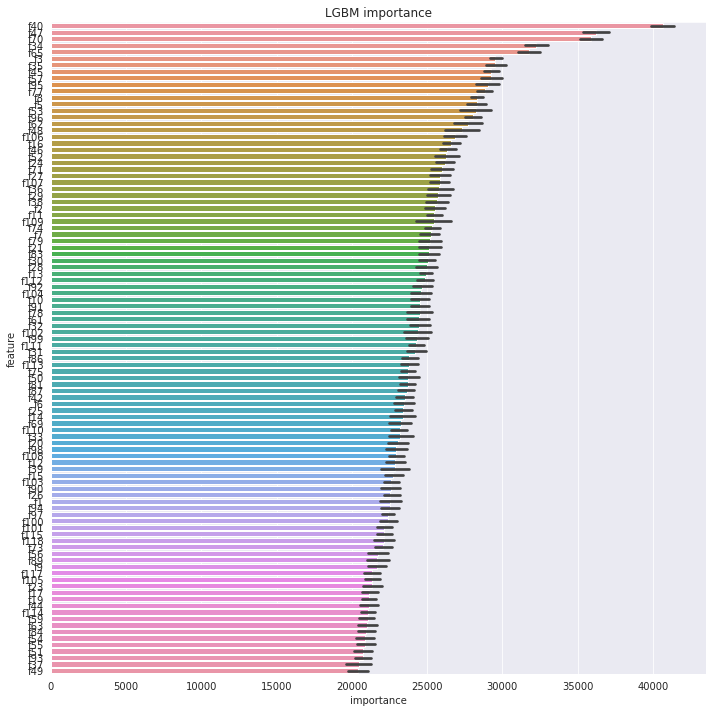

In [19]:
# 特徴量重要度を保管する dataframe を用意
feature_importances = pd.DataFrame()

for fold, model in enumerate(models):

    tmp = pd.DataFrame()
    tmp['feature'] = model.feature_name()
    tmp['importance'] = model.feature_importance(importance_type='gain')
    tmp['fold'] = fold

    feature_importances = feature_importances.append(tmp)

# 各特徴量で集約して、重要度の平均を算出。上位50個だけ抜き出す
order = list(feature_importances.groupby("feature")["importance"].mean().sort_values(ascending=False).index)[:100]

# 可視化
plt.figure(figsize=(10, 10))
sns.barplot(x='importance', y='feature', data=feature_importances, order=order)
plt.title('LGBM importance')
plt.tight_layout()
plt.show()

# prediction

## 実際の対象データをモデル実行する

In [20]:
preds = np.zeros(len(pred_df))

# 各モデルで推論
for model in models:
    pred = model.predict(pred_df.drop(columns='id'), num_iteration=model.best_iteration)
    preds += pred / len(models)

## 提出用データを作成

In [21]:
submission = pd.DataFrame({
   'id' : pred_df['id'],
    'claim' : preds
})

In [22]:
submission.head()

,id,claim
0,957919,0.452699
1,957920,0.251550
2,957921,0.479915
3,957922,0.329379
4,957923,0.260912


In [23]:
submission.to_csv('submission.csv', index=False)